In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._


//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.7.1`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    .config("spark.executor.instances", "4") // Número de ejecutores
    .config("spark.executor.memory", "4g") // Memoria por ejecutor
    .config("spark.executor.cores", "2") // Núcleos por ejecutor
    .config("spark.driver.memory", "4g") // Memoria del driver
    .config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$                                  



import org.apache.spark.sql._

import org.apache.spark.sql.functions._


//Reducir numero logs

import org.apache.log4j.{Level, Logger}

import $ivy.$                               

//Plotly

import $ivy.$                                      

import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@380883e2
import spark.implicits._

In [18]:
val filePath = "../../data/parquet/dsMercadoNacionalTotal.parquet"

val dsMercados: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePath)


parquet at cmd17.sc:7

1 / 1

filePath: String = "../../data/parquet/dsMercadoNacionalTotal.parquet"
dsMercados: DataFrame = [Fecha: timestamp, Valor_Mercado_Spot: double ... 3 more fields]

In [60]:
val filePath = "../../data/parquet/dsItercambiosFronteras14-24.parquet"         
val dsIntercambios: DataFrame = spark.read
  //.option("header", "true") // Si el archivo tiene un encabezado
  //.option("inferSchema", "true") // Para inferir automáticamente el esquema
  //.csv(filePath)
    .parquet(filePath)

parquet at cmd59.sc:6

1 / 1

filePath: String = "../../data/parquet/dsItercambiosFronteras14-24.parquet"
dsIntercambios: DataFrame = [Pais: string, TipoIntercambio: string ... 3 more fields]

In [61]:
dsIntercambios
    .show()

show at cmd60.sc:1

1 / 1

+-------+---------------+--------------------+--------+-------------------+
|   Pais|TipoIntercambio|          Porcentaje|   Valor|              Fecha|
+-------+---------------+--------------------+--------+-------------------+
|francia|    Exportación|0.040690692391790774| -2873.3|2022-01-01 00:00:00|
|francia|    Exportación| 0.03352963228112584| -2674.3|2022-01-02 00:00:00|
|francia|    Exportación|  0.0789662326013408| -6444.3|2022-01-03 00:00:00|
|francia|    Exportación|  0.7276761833404483|-41761.7|2022-01-04 00:00:00|
|francia|    Exportación|  0.8014993776168383|-42497.1|2022-01-05 00:00:00|
|francia|    Exportación|  0.7308582244652934|-40967.6|2022-01-06 00:00:00|
|francia|    Exportación|  0.5497382537741282|-33982.4|2022-01-07 00:00:00|
|francia|    Exportación|  0.1586140723335776|-10497.0|2022-01-08 00:00:00|
|francia|    Exportación|  0.9295050738441702|-64164.2|2022-01-09 00:00:00|
|francia|    Exportación|  0.8685587806707862|-58234.0|2022-01-10 00:00:00|
|francia|   

In [55]:
spark.conf.set("spark.sql.session.timeZone", "UTC") // O el huso horario deseado

dsIntercambios
    .withColumn("FechaPrueba", $"FechaCompleta".cast("timestamp"))
    .withColumn("FechaPrueba2", to_timestamp(col("Fecha"), "yyyy-MM-dd'T'HH:mm:ss"))
    .withColumn("FechaPrueba3", from_utc_timestamp(col("Fecha"), "UTC"))
    .withColumn("FechaPrueba4", expr("to_timestamp(Fecha, 'yyyy-MM-dd HH:mm:ss') + INTERVAL 1 HOUR"))
    .select($"FechaCompleta",$"FechaPrueba", $"FechaPrueba2",$"FechaPrueba3",$"FechaPrueba4")
    .orderBy($"Fecha")
    .show()

: 

In [20]:
dsIntercambios
    .withColumn("FechaDiaria", date_format("Fecha", "yyyy-MM-dd"))
    .drop("Fecha")
    .show()

cmd20.sc:2: type mismatch;
 found   : String("Fecha")
 required: org.apache.spark.sql.Column
    .withColumn("FechaDiaria", date_format("Fecha", "yyyy-MM-dd"))
                                           ^Compilation Failed

: 

In [17]:
val mercadoDiario = dsMercados
    .groupBy(date_format($"Fecha", "yyyy-MM-dd").as("FechaDiaria"))
    .agg(avg($"Valor_Mercado_Spot").as("Precio_energía"))

mercadoDiario: DataFrame = [FechaDiaria: string, Precio_energía: double]

In [12]:
val intercambiosYmercados = dsIntercambios.join(dsMercados,,"inner").show()

cmd12.sc:1: not found: value dsMercados
val intercambiosYmercados = dsIntercambios.join(dsMercados, "inner").show()
                                                ^Compilation Failed

: 

In [15]:
val exportacionFrancia = dsIntercambios
    .filter($"Pais" === "francia")
    .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"), $"TipoIntercambio")
    .agg(sum("Valor").as("ValorTotal"))
    .orderBy($"TipoIntercambio", $"Año")
    .show()

show at cmd14.sc:5

12 / 12

show at cmd14.sc:5

8 / 8

+----+---------------+--------------------+
| Año|TipoIntercambio|          ValorTotal|
+----+---------------+--------------------+
|2013|    Exportación|            -22491.0|
|2014|    Exportación| -2884650.6999999997|
|2015|    Exportación| -1979028.2000000002|
|2016|    Exportación|  -5486154.499999994|
|2017|    Exportación|  -4605353.099999999|
|2018|    Exportación| -3867988.6000000006|
|2019|    Exportación| -4176284.9999999986|
|2020|    Exportación|  -7856427.899999996|
|2021|    Exportación|  -8622824.500000002|
|2022|    Exportación|-1.53847737580000...|
|2023|    Exportación|-1.16264010119999...|
|2024|    Exportación|        -1068379.434|
|2013|    Importación|              5214.0|
|2014|    Importación|   6486299.600000002|
|2015|    Importación|   9301541.000000002|
|2016|    Importación|1.3308686899999997E7|
|2017|    Importación|        1.70447231E7|
|2018|    Importación| 1.595512720000001E7|
|2019|    Importación|1.3820046900000002E7|
|2020|    Importación|1.30397028

collect at cmd11.sc:10

12 / 12

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:10

8 / 8

collect at cmd11.sc:11

12 / 12

collect at cmd11.sc:11

8 / 8

collect at cmd11.sc:11

8 / 8

collect at cmd11.sc:11

8 / 8

collect at cmd11.sc:12

12 / 12

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

collect at cmd11.sc:12

8 / 8

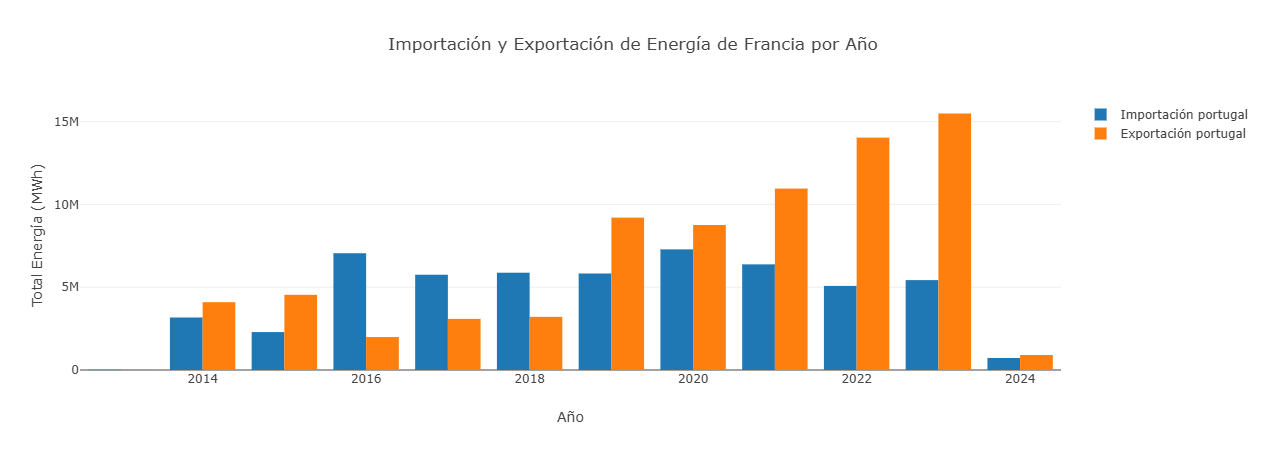

defined function importaciónVSexportacion

In [12]:
def importaciónVSexportacion(pais: String, df: DataFrame): Unit = {

    // Agrupar los datos por año y tipo de intercambio (Importación/Exportación)
    val dfAgrupado = df
      .filter($"Pais" === pais)
      .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"), $"TipoIntercambio")
      .agg(sum("Valor").as("TotalValor"))
      .orderBy("Año", "TipoIntercambio")

    val años = dfAgrupado.select("Año").distinct().orderBy("Año").as[String].collect.toSeq
    val importaciones = dfAgrupado.filter(col("TipoIntercambio") === "Importación").select("TotalValor").as[Double].collect.toSeq
    val exportaciones = dfAgrupado.filter(col("TipoIntercambio") === "Exportación").select("TotalValor").as[Double].collect.toSeq

    val exportacionesEnPositivo = exportaciones.map(valor => valor * -1)

    // Crear las barras para importación y exportación con valores absolutos
    val barraImportacion = Bar(x = años, y = importaciones, name = s"Importación $pais")
    val barraExportacion = Bar(x = años, y = exportacionesEnPositivo, name = s"Exportación $pais")

    // Definir los datos y el layout del gráfico
    val data = Seq(barraImportacion, barraExportacion)
    val layout = Layout(
      title = "Importación y Exportación de Energía de" +  pais + "por Año",
      xaxis = Axis(title = "Año"),
      yaxis = Axis(title = "Total Energía (MWh)"),
      barmode = BarMode.Group // Agrupar barras para compararlas lado a lado
    )

    // Generar el gráfico
    plot(data, layout)
}

importaciónVSexportacion("portugal", dsIntercambios )

In [13]:
dsIntercambios
    .filter($"Pais" === "francia")
    .groupBy(date_format(col("FechaCompleta"), "yyyy").as("Año"), $"TipoIntercambio")
    .agg(sum("Valor").as("TotalValor"))
    .orderBy("Año", "TipoIntercambio")
    .show()

show at cmd12.sc:5

12 / 12

show at cmd12.sc:5

8 / 8

+----+---------------+--------------------+
| Año|TipoIntercambio|          TotalValor|
+----+---------------+--------------------+
|2013|    Exportación|            -22491.0|
|2013|    Importación|              5214.0|
|2013|          saldo|            -17277.0|
|2014|    Exportación| -2884650.6999999997|
|2014|    Importación|   6486299.600000002|
|2014|          saldo|  3601648.9000000004|
|2015|    Exportación| -1979028.2000000002|
|2015|    Importación|   9301541.000000002|
|2015|          saldo|           7322512.8|
|2016|    Exportación|  -5486154.499999994|
|2016|    Importación|1.3308686899999997E7|
|2016|          saldo|   7822532.400000001|
|2017|    Exportación|  -4605353.099999999|
|2017|    Importación|        1.70447231E7|
|2017|          saldo|1.2439369999999998E7|
|2018|    Exportación| -3867988.6000000006|
|2018|    Importación| 1.595512720000001E7|
|2018|          saldo|1.2087138599999996E7|
|2019|    Exportación| -4176284.9999999986|
|2019|    Importación|1.38200469